In [14]:
#importing necessary packages
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [15]:
#loading dataset into colab 
#dataset taken from https://github.com/Mainak1792/Backround_Subtraction/blob/main/assets/umcp.mpg
#taken from this StackOverflow answer: https://stackoverflow.com/a/39225039
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)


file_id = '19lzP39wadV-Pe5iWXwRDziys6kDu6LDX'
destination = '/content/dataset.mpg'
download_file_from_google_drive(file_id, destination)

In [16]:
#Displaying the video dataset
#taken from https://stackoverflow.com/questions/57377185/how-play-mp4-video-in-google-colab
from IPython.display import HTML
from base64 import b64encode
import os

# Input video path
save_path = "/content/dataset.mpg"

# Compressed video path
compressed_path = "/content/result_compressed.mp4"

os.system(f"ffmpeg -i {save_path} -vcodec libx264 {compressed_path}")

# Show video
mp4 = open(compressed_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [17]:
#creating multiple frames from video dataset
vid = cv2.VideoCapture(r"dataset.mpg")
frames = []
frame_count = 0
count = 0
while True:
    ret, frame = vid.read()
    if frame is not None:
        #convert RGB image frame to grayscale
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        #considering every 50th frame for our model
        if ( frame_count % 50 == 0):
          frames.append(frame)
          count += 1
        frame_count += 1
    else:
        break
frames = np.array(frames)



In [18]:
print("Number of frames extracted is {}".format(count))

Number of frames extracted is 20


In [19]:
print("array dimensions will be (num_frames, image_width, image_height)")
print("Shape of frames is {}".format(frames.shape))

array dimensions will be (num_frames, image_width, image_height)
Shape of frames is (20, 240, 352)


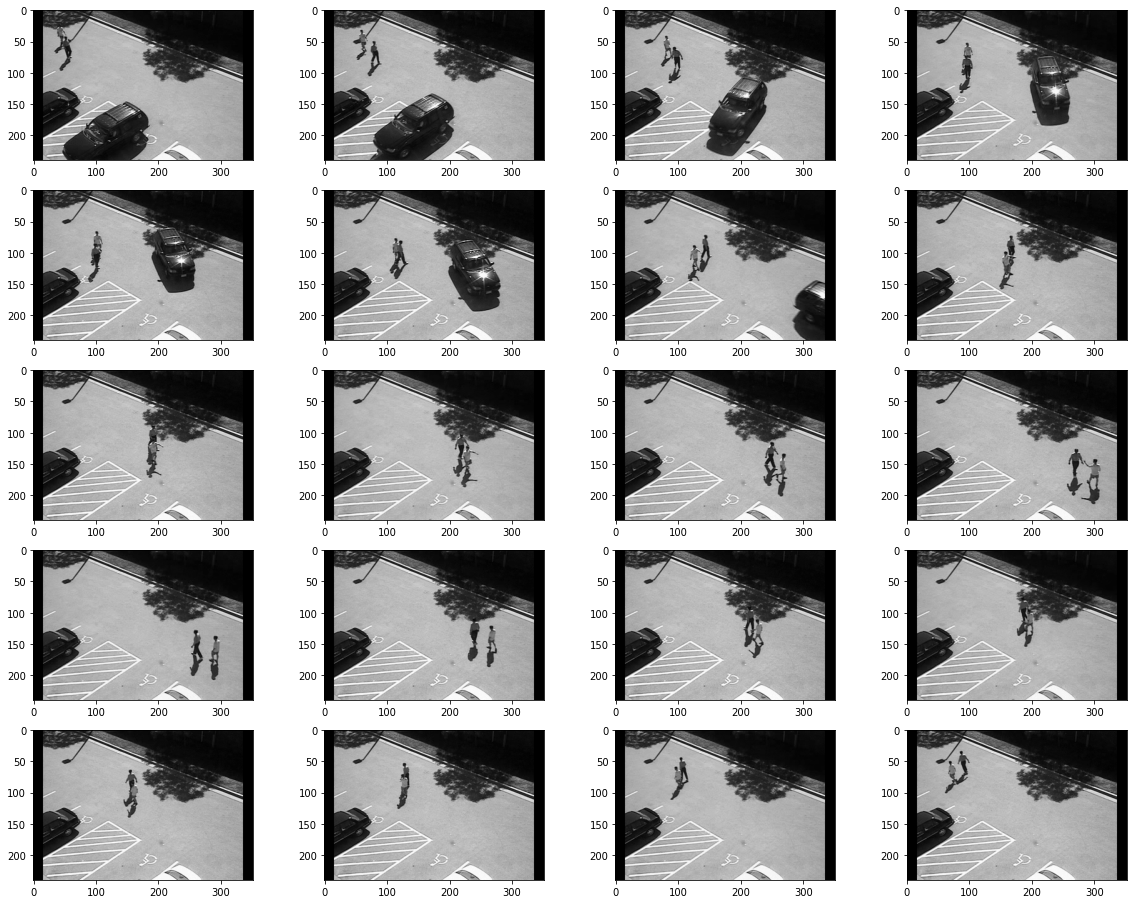

In [20]:
#dispaly all background image frames
fig = plt.figure(figsize=(20, 16))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = frames[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap="gray")
plt.show()

In [21]:
#Probability Density Function
def pdf(data, mean: float, variance: float):
  s1 = 1/(np.sqrt(2*np.pi*variance))
  s2 = np.exp(-(np.square(data - mean)/(2*variance)))
  return s1 * s2

In [22]:
import warnings
warnings.filterwarnings("ignore")

#initialize background images
background = np.zeros((240, 352)).astype(np.uint8)

#looping for every pixel in all the frames 
for g in range(frames.shape[1]):
      for h in range(frames.shape[2]):
        
            X = frames[:, g, h]
            #print(X.shape)
            
            X = X.flatten()
           
            #print(X.shape)


            k = 2    # number of cluster for Gaussian mixture model
            weights = np.ones((k)) / k   #initilize weight for every cluster
            means = np.random.choice(X, k) # initilize mean value with random value from dataset
            variances = np.random.random_sample(size=k)
            #print(means, variances)


            eps=1e-8
            for step in range(5):
                # calculate the maximum likelihood of each observation xi
                likelihood = []
                

                # Expectation step
                for j in range(k):
                  likelihood.append(pdf(X, means[j], np.sqrt(variances[j])))
                likelihood = np.array(likelihood)
                  
                b = []
                # Maximization step 
                for j in range(k):
                    # use the current values for the parameters to evaluate the posterior
                    # probabilities of the data to have been generanted by each gaussian    
                    b.append((likelihood[j] * weights[j]) / (np.sum([likelihood[a] * weights[a] for a in range(k)])+eps))
                  
                    # updage mean and variance
                    means[j] = np.sum(b[j] * X) / (np.sum(b[j]+eps))
                    variances[j] = np.sum(b[j] * np.square(X - means[j])) / (np.sum(b[j]+eps))
                    
                    # update the weights
                    weights[j] = np.mean(b[j])
                 
            idx = np.argmax(weights)
            
            
            background[g][h] =  means[idx]
            
              #break
      #break
            
            
        


In [23]:
#storing thus obtained background image
cv2.imwrite('background.png',background)

True

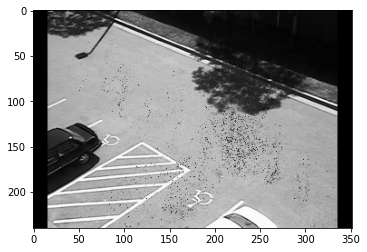

In [24]:
#plotting background image

fig, axes = plt.subplots()
axes.imshow(background, cmap="gray")
plt.show()

In [25]:
#from each frame, calculate forground by subtracting background and storing it
forgrd = []
for i in range(frames.shape[0]):
  cv2.imwrite('foreground{}.png'.format(i),(cv2.absdiff(frames[i],background)))
  forgrd.append(cv2.absdiff(frames[i],background))

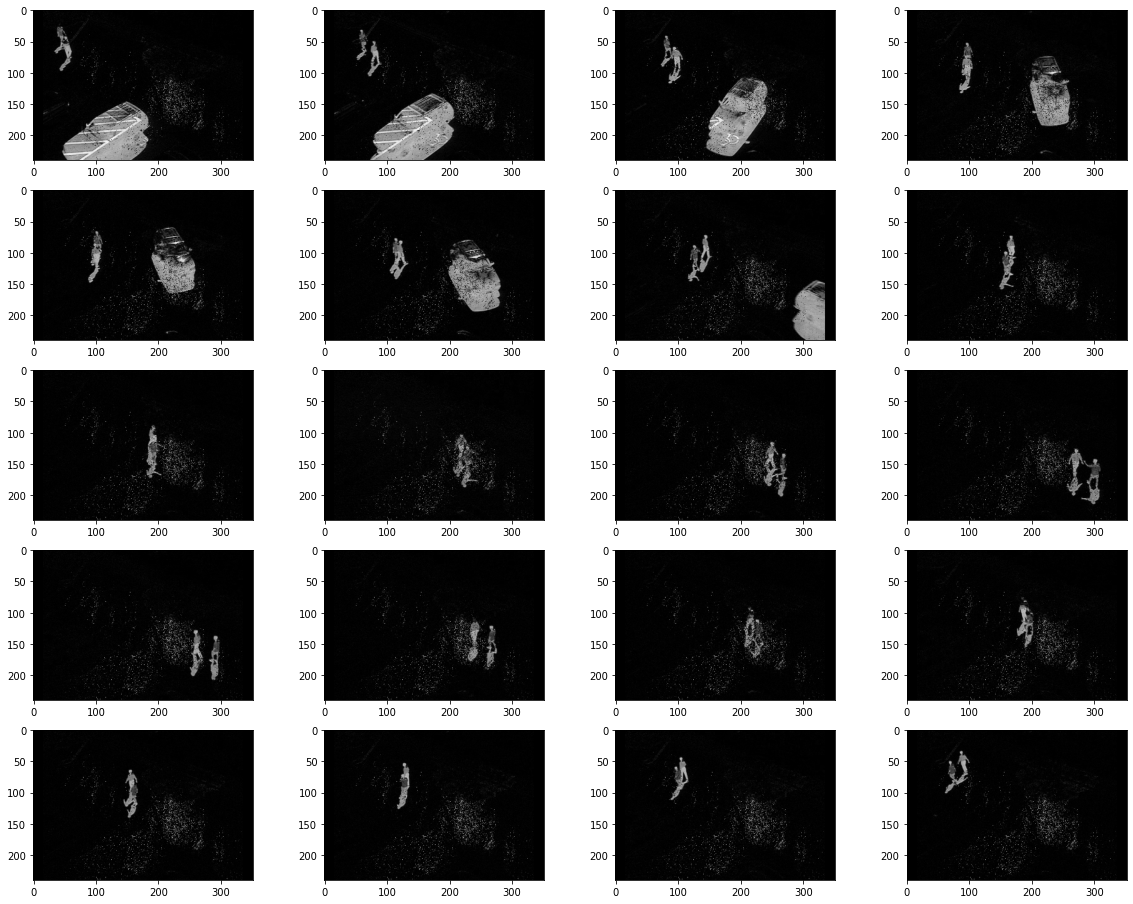

In [26]:
#dispaly all foreground images
fig = plt.figure(figsize=(20, 16))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = forgrd[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap="gray")
plt.show()

In [27]:
#creating gif out of the multiple foreground frames
import imageio
images = []
for i in range(frames.shape[0]):
  images.append((cv2.absdiff(frames[i],background)))
imageio.mimsave('foreground.gif',images)

In [28]:
#loading interactiveShell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

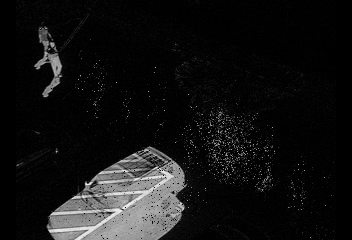

In [29]:

from IPython import display
# Display GIF 
with open('foreground.gif','rb') as f:
    display.Image(data=f.read(), format='png')

**Accuracy Analysis**


In [30]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

In [31]:

#using built-in library to obtain foreground image
vid = cv2.VideoCapture(r"dataset.mpg")
frame_count = 0
i = 0

# initializing subtractor
fgbg = cv2.createBackgroundSubtractorMOG2()
while True:
  
  ret, frame = vid.read()
  if frame is not None:
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    if( frame_count % 50 == 0):
      # applying on each frame
      fgmask = fgbg.apply(frame)
      cv2.imwrite('foregroundtest{}.png'.format(i),fgmask)
      i += 1
    frame_count += 1
    
    
  else:
    break

In [32]:
#last frame in consideration for observed an actual frame
observed = cv2.imread('foreground19.png')
observed = cv2.cvtColor(observed, cv2.COLOR_BGR2GRAY)
print(observed.shape)

actual = cv2.imread('foregroundtest19.png')
actual = cv2.cvtColor(actual, cv2.COLOR_BGR2GRAY)
print(actual.shape)

(240, 352)
(240, 352)


In [33]:
#calculate diff betn observed and actual frame
diff = cv2.absdiff(observed,actual)
print ( diff.shape)

(240, 352)


In [34]:
#taking 5 as threshold for diff in pixel value to be considered as a match
match_count = 0
for i in range(diff.shape[0]):
  for j in range(diff.shape[1]):
    if ( diff[i][j] < 5):
      match_count +=1

print( "Accuracy is {}%".format(100*match_count/(diff.shape[0]*diff.shape[1])))

Accuracy is 85.23555871212122%
